In [46]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
housedf = pd.read_csv('./data/Ames_HousePrice_processed.csv')

In [48]:
housedf.columns

Index(['Unnamed: 0', 'PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
     

Note that we have many identifying columns, such as PID and MA_Ownr1. We will specify which columns contain suitable features.

In [49]:
featurecolumns = ['GrLivArea', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'ExteriorSF']

In [50]:
X = housedf[featurecolumns]
y = housedf['SalePrice']

In [51]:
X_enc = sm.add_constant(pd.get_dummies(X, drop_first = True))

In [52]:
model = sm.OLS(y, X_enc).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     138.1
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:48:27   Log-Likelihood:                -29017.
No. Observations:                2579   AIC:                         5.855e+04
Df Residuals:                    2322   BIC:                         6.005e+04
Df Model:                         256                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

We get an adjusted R-squared of 93.2%. We are likely overfitting, probably due to multicollinearity. High multicollinearity is indicated by an extremely high condition number of 1.56e+16. Let's investigate this.

In [53]:
# display correlations of all feature pairs (except self-pairs and duplicate pairs) sorted by value.
# approach is to melt the top half of the correlation matrix except the diagonal

def display_sorted_corrs(df, corr_threshold=0.7):
    temp = df.corr()

    # set values at and below the diagonal to NaN. Adapted from SO user jezrael (https://stackoverflow.com/questions/34417685/melt-the-upper-triangular-matrix-of-a-pandas-dataframe)
    temp = temp.where(np.triu(np.ones(temp.shape)).astype(bool)) 
    temp.values[[np.arange(temp.shape[0])]*2] = np.nan

    # stack and sort by highest-to-lowest absolute magnitudes of correlations
    temp = temp.stack().reset_index()
    temp.columns = ('Feature 1', 'Feature 2', 'Correlation')
    sorted_indices = temp['Correlation'].abs().argsort().loc[::-1]
    temp = temp.loc[sorted_indices,:]

    with pd.option_context('display.max_rows', None,):
        display(temp.loc[temp['Correlation'].abs() > corr_threshold])

display_sorted_corrs(X_enc)

/var/folders/j2/lf9zt3017c3fz8rrnty2f8h80000gn/T/ipykernel_1333/1534894529.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp.values[[np.arange(temp.shape[0])]*2] = np.nan


,Feature 1,Feature 2,Correlation
30976,BsmtCond_No basement,BsmtFinType1_No basement,1.000000
34619,GarageQual_No garage,GarageCond_No garage,1.000000
34429,GarageType_No garage,GarageQual_No garage,1.000000
30512,BsmtQual_No basement,BsmtFinType2_No basement,1.000000
34434,GarageType_No garage,GarageCond_No garage,1.000000
30502,BsmtQual_No basement,BsmtExposure_No basement,1.000000
30972,BsmtCond_No basement,BsmtExposure_No basement,1.000000
30496,BsmtQual_No basement,BsmtCond_No basement,1.000000
30982,BsmtCond_No basement,BsmtFinType2_No basement,1.000000
31507,BsmtExposure_No basement,BsmtFinType1_No basement,1.000000


In [54]:
def display_sorted_vifs(df):
    # build a dataframe listing the VIF for each feature
    vif_df= pd.DataFrame({
        'Feature': df.columns,
        'VIF': [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    })
    
    sorted_indices = vif_df['VIF'].argsort().loc[::-1]
    sorted_df = vif_df.loc[sorted_indices,:]
    
    with pd.option_context('display.max_rows', None,):
        display(sorted_df)
        

# display_sorted_vifs(X_enc)

In [59]:
def get_highest_vif(df):
    # build a dataframe listing the VIF for each feature
    vif_df= pd.DataFrame({
        'Feature': df.columns,
        # note: function's author notes that variance_inflation_factor assumes we have a constant
        # (https://github.com/statsmodels/statsmodels/issues/2376)
        'VIF': [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    })
    
    
    sorted_indices = vif_df['VIF'].argsort().loc[::-1]
    sorted_df = vif_df.loc[sorted_indices,:]
    
    highest_vif = sorted_df.iloc[0,:]
    
    if highest_vif['Feature'] == 'const':
        # hack fix to prevent dropping the constant column
        highest_vif = sorted_df.iloc[1,:]
    
    return highest_vif

# get_highest_vif(X_enc)

In [56]:
def VIF_trim(df, threshold = 5):
    df_subset = df.copy()
    
    while True:
        if len(df_subset.columns) == 0:
            return df_subset
        display_sorted_vifs(df_subset)
        highest_vif = get_highest_vif(df_subset)
        
        if highest_vif['VIF'] < threshold:
            return df_subset
        
        df_subset = df_subset.drop(highest_vif['Feature'], axis=1)

In [60]:
# the following one hot encodings are perfectly multicollinear with other indicators
X_enc_2 = X_enc.drop(['BsmtFinType1_No basement', 'GarageQual_No garage',
                      'BsmtFinType2_No basement', 'BsmtExposure_No basement',
                      'BsmtCond_No basement'], axis=1)

In [61]:
X_vif_subset = VIF_trim(X_enc_2, threshold=10)
display(X_vif_subset)

/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
221,GarageType_No garage,inf
145,Exterior2nd_PreCast,inf
1,GrLivArea,inf
3,LotArea,inf
9,BsmtFinSF1,inf
10,BsmtFinSF2,inf
11,BsmtUnfSF,inf
12,TotalBsmtSF,inf
230,GarageCond_No garage,inf
13,1stFlrSF,inf


/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
131,Exterior1st_PreCast,inf
1,GrLivArea,inf
3,LotArea,inf
9,BsmtFinSF1,inf
10,BsmtFinSF2,inf
11,BsmtUnfSF,inf
12,TotalBsmtSF,inf
13,1stFlrSF,inf
14,2ndFlrSF,inf
15,LowQualFinSF,inf


/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
1,GrLivArea,inf
3,LotArea,inf
9,BsmtFinSF1,inf
10,BsmtFinSF2,inf
11,BsmtUnfSF,inf
12,TotalBsmtSF,inf
13,1stFlrSF,inf
14,2ndFlrSF,inf
15,LowQualFinSF,inf
35,ExteriorSF,inf


/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
34,ExteriorSF,inf
2,LotArea,inf
8,BsmtFinSF1,inf
9,BsmtFinSF2,inf
10,BsmtUnfSF,inf
11,TotalBsmtSF,inf
12,1stFlrSF,inf
0,const,2.812373e+06
39,MSZoning_RL,1.403113e+03
40,MSZoning_RM,1.119671e+03


/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
8,BsmtFinSF1,inf
9,BsmtFinSF2,inf
10,BsmtUnfSF,inf
11,TotalBsmtSF,inf
0,const,2.812373e+06
38,MSZoning_RL,1.403113e+03
39,MSZoning_RM,1.119671e+03
35,MSZoning_FV,3.449432e+02
223,GarageQual_TA,1.909256e+02
228,GarageCond_TA,1.475232e+02


/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,const,2.812373e+06
37,MSZoning_RL,1.403113e+03
38,MSZoning_RM,1.119671e+03
34,MSZoning_FV,3.449432e+02
222,GarageQual_TA,1.909256e+02
227,GarageCond_TA,1.475232e+02
144,Exterior2nd_VinylSd,1.109504e+02
108,RoofStyle_Gable,1.094210e+02
129,Exterior1st_VinylSd,1.065518e+02
110,RoofStyle_Hip,1.031590e+02


,Feature,VIF
0,const,2.808446e+06
221,GarageQual_TA,1.909069e+02
226,GarageCond_TA,1.475231e+02
143,Exterior2nd_VinylSd,1.106611e+02
107,RoofStyle_Gable,1.092225e+02
128,Exterior1st_VinylSd,1.062829e+02
109,RoofStyle_Hip,1.029983e+02
169,BsmtCond_TA,8.992296e+01
218,GarageQual_Fa,8.604295e+01
237,MiscFeature_No misc feature,7.095716e+01


,Feature,VIF
0,const,2.808267e+06
143,Exterior2nd_VinylSd,1.106527e+02
107,RoofStyle_Gable,1.092223e+02
128,Exterior1st_VinylSd,1.062801e+02
109,RoofStyle_Hip,1.029965e+02
169,BsmtCond_TA,8.992251e+01
225,GarageCond_TA,7.342548e+01
236,MiscFeature_No misc feature,7.094636e+01
138,Exterior2nd_MetalSd,6.946368e+01
125,Exterior1st_MetalSd,6.612235e+01


,Feature,VIF
0,const,2.804037e+06
107,RoofStyle_Gable,1.092070e+02
109,RoofStyle_Hip,1.029825e+02
168,BsmtCond_TA,8.947948e+01
224,GarageCond_TA,7.342374e+01
235,MiscFeature_No misc feature,7.093489e+01
29,PoolArea,5.890079e+01
237,MiscFeature_Shed,5.830026e+01
222,GarageCond_No garage,5.410967e+01
182,Heating_GasA,4.478850e+01


,Feature,VIF
0,const,2.803513e+06
167,BsmtCond_TA,8.947092e+01
223,GarageCond_TA,7.342242e+01
234,MiscFeature_No misc feature,7.063715e+01
29,PoolArea,5.889384e+01
236,MiscFeature_Shed,5.807171e+01
221,GarageCond_No garage,5.410717e+01
181,Heating_GasA,4.478652e+01
209,GarageType_Attchd,3.862634e+01
165,BsmtCond_Gd,3.760897e+01


,Feature,VIF
0,const,2.803428e+06
222,GarageCond_TA,7.342145e+01
233,MiscFeature_No misc feature,7.063687e+01
29,PoolArea,5.888846e+01
235,MiscFeature_Shed,5.807163e+01
220,GarageCond_No garage,5.410716e+01
180,Heating_GasA,4.478637e+01
208,GarageType_Attchd,3.861655e+01
124,Exterior1st_MetalSd,3.746511e+01
145,MasVnrType_None,3.570050e+01


,Feature,VIF
0,const,2.802368e+06
232,MiscFeature_No misc feature,7.063550e+01
29,PoolArea,5.888400e+01
234,MiscFeature_Shed,5.806952e+01
180,Heating_GasA,4.478618e+01
208,GarageType_Attchd,3.861456e+01
124,Exterior1st_MetalSd,3.746125e+01
145,MasVnrType_None,3.570025e+01
153,ExterCond_TA,3.271137e+01
241,SaleType_New,3.268081e+01


,Feature,VIF
0,const,2.802328e+06
29,PoolArea,5.888400e+01
180,Heating_GasA,4.478615e+01
208,GarageType_Attchd,3.860955e+01
124,Exterior1st_MetalSd,3.746065e+01
145,MasVnrType_None,3.569268e+01
153,ExterCond_TA,3.270964e+01
240,SaleType_New,3.267418e+01
248,SaleCondition_Partial,3.239550e+01
144,MasVnrType_BrkFace,3.198707e+01


,Feature,VIF
0,const,2.800111e+06
179,Heating_GasA,4.477718e+01
207,GarageType_Attchd,3.831790e+01
123,Exterior1st_MetalSd,3.746024e+01
144,MasVnrType_None,3.568833e+01
152,ExterCond_TA,3.270962e+01
239,SaleType_New,3.267281e+01
247,SaleCondition_Partial,3.239550e+01
143,MasVnrType_BrkFace,3.197283e+01
211,GarageType_Detchd,3.163573e+01


,Feature,VIF
0,const,2.797181e+06
206,GarageType_Attchd,3.830740e+01
123,Exterior1st_MetalSd,3.745955e+01
144,MasVnrType_None,3.568690e+01
152,ExterCond_TA,3.270919e+01
238,SaleType_New,3.267242e+01
246,SaleCondition_Partial,3.239543e+01
143,MasVnrType_BrkFace,3.197077e+01
210,GarageType_Detchd,3.162674e+01
120,Exterior1st_CemntBd,3.061459e+01


,Feature,VIF
0,const,2.794627e+06
123,Exterior1st_MetalSd,3.739581e+01
144,MasVnrType_None,3.568381e+01
152,ExterCond_TA,3.270898e+01
237,SaleType_New,3.267091e+01
245,SaleCondition_Partial,3.239385e+01
143,MasVnrType_BrkFace,3.196918e+01
120,Exterior1st_CemntBd,3.059950e+01
121,Exterior1st_HdBoard,2.945752e+01
133,Exterior2nd_CmentBd,2.940611e+01


,Feature,VIF
0,const,2.791735e+06
143,MasVnrType_None,3.563155e+01
236,SaleType_New,3.267071e+01
151,ExterCond_TA,3.256821e+01
244,SaleCondition_Partial,3.239378e+01
142,MasVnrType_BrkFace,3.190493e+01
132,Exterior2nd_CmentBd,2.930455e+01
120,Exterior1st_CemntBd,2.893045e+01
202,FireplaceQu_No fireplace,2.878767e+01
149,ExterCond_Gd,2.715464e+01


,Feature,VIF
0,const,2.791547e+06
235,SaleType_New,3.266371e+01
150,ExterCond_TA,3.256740e+01
243,SaleCondition_Partial,3.239371e+01
132,Exterior2nd_CmentBd,2.929662e+01
120,Exterior1st_CemntBd,2.891757e+01
201,FireplaceQu_No fireplace,2.878254e+01
148,ExterCond_Gd,2.715458e+01
67,Neighborhood_NAmes,2.501674e+01
146,ExterQual_TA,2.129961e+01


,Feature,VIF
0,const,2.788619e+06
150,ExterCond_TA,3.256682e+01
132,Exterior2nd_CmentBd,2.929662e+01
120,Exterior1st_CemntBd,2.891755e+01
201,FireplaceQu_No fireplace,2.875056e+01
148,ExterCond_Gd,2.715388e+01
67,Neighborhood_NAmes,2.500320e+01
146,ExterQual_TA,2.129283e+01
72,Neighborhood_OldTown,1.935038e+01
125,Exterior1st_VinylSd,1.833403e+01


,Feature,VIF
0,const,2.788539e+06
132,Exterior2nd_CmentBd,2.927589e+01
120,Exterior1st_CemntBd,2.890778e+01
200,FireplaceQu_No fireplace,2.874251e+01
67,Neighborhood_NAmes,2.500023e+01
146,ExterQual_TA,2.120704e+01
72,Neighborhood_OldTown,1.932826e+01
125,Exterior1st_VinylSd,1.827026e+01
121,Exterior1st_HdBoard,1.757392e+01
133,Exterior2nd_HdBoard,1.703558e+01


,Feature,VIF
0,const,2.787886e+06
199,FireplaceQu_No fireplace,2.874184e+01
67,Neighborhood_NAmes,2.498826e+01
145,ExterQual_TA,2.120696e+01
72,Neighborhood_OldTown,1.932270e+01
125,Exterior1st_VinylSd,1.761301e+01
121,Exterior1st_HdBoard,1.749194e+01
144,ExterQual_Gd,1.677013e+01
198,FireplaceQu_Gd,1.638737e+01
132,Exterior2nd_HdBoard,1.632328e+01


,Feature,VIF
0,const,2.787846e+06
67,Neighborhood_NAmes,2.498114e+01
145,ExterQual_TA,2.114377e+01
72,Neighborhood_OldTown,1.932108e+01
125,Exterior1st_VinylSd,1.760357e+01
121,Exterior1st_HdBoard,1.749178e+01
144,ExterQual_Gd,1.670313e+01
132,Exterior2nd_HdBoard,1.632190e+01
12,2ndFlrSF,1.464599e+01
126,Exterior1st_Wd Sdng,1.389447e+01


,Feature,VIF
0,const,2.784348e+06
144,ExterQual_TA,2.113082e+01
124,Exterior1st_VinylSd,1.759872e+01
120,Exterior1st_HdBoard,1.749123e+01
143,ExterQual_Gd,1.670243e+01
131,Exterior2nd_HdBoard,1.631823e+01
12,2ndFlrSF,1.464533e+01
125,Exterior1st_Wd Sdng,1.389426e+01
138,Exterior2nd_Wd Sdng,1.324140e+01
5,YearBuilt,1.282101e+01


,Feature,VIF
0,const,2.781781e+06
124,Exterior1st_VinylSd,1.758729e+01
120,Exterior1st_HdBoard,1.749119e+01
131,Exterior2nd_HdBoard,1.630663e+01
12,2ndFlrSF,1.462085e+01
125,Exterior1st_Wd Sdng,1.389424e+01
138,Exterior2nd_Wd Sdng,1.323287e+01
5,YearBuilt,1.281427e+01
172,BsmtFinType2_Unf,1.245428e+01
194,Functional_Typ,1.204946e+01


,Feature,VIF
0,const,2.781781e+06
120,Exterior1st_HdBoard,1.489134e+01
12,2ndFlrSF,1.462037e+01
130,Exterior2nd_HdBoard,1.435906e+01
5,YearBuilt,1.279141e+01
171,BsmtFinType2_Unf,1.245166e+01
193,Functional_Typ,1.202978e+01
137,Exterior2nd_Wd Sdng,1.164381e+01
124,Exterior1st_Wd Sdng,1.158207e+01
155,BsmtQual_TA,1.155982e+01


,Feature,VIF
0,const,2.781080e+06
12,2ndFlrSF,1.461483e+01
5,YearBuilt,1.268276e+01
170,BsmtFinType2_Unf,1.244333e+01
192,Functional_Typ,1.201916e+01
154,BsmtQual_TA,1.155144e+01
186,KitchenQual_TA,1.059642e+01
10,TotalBsmtSF,1.008940e+01
88,Condition2_Norm,9.766758e+00
11,1stFlrSF,9.294845e+00


,Feature,VIF
0,const,2.778892e+06
5,YearBuilt,1.258693e+01
169,BsmtFinType2_Unf,1.244200e+01
191,Functional_Typ,1.198829e+01
153,BsmtQual_TA,1.150892e+01
185,KitchenQual_TA,1.058679e+01
10,TotalBsmtSF,1.008565e+01
87,Condition2_Norm,9.749977e+00
151,BsmtQual_No basement,8.635710e+00
11,1stFlrSF,8.569234e+00


,Feature,VIF
0,const,2.718595e+06
168,BsmtFinType2_Unf,1.241285e+01
190,Functional_Typ,1.198826e+01
152,BsmtQual_TA,1.128207e+01
184,KitchenQual_TA,1.056160e+01
9,TotalBsmtSF,9.987006e+00
86,Condition2_Norm,9.694935e+00
150,BsmtQual_No basement,8.618457e+00
182,KitchenQual_Gd,8.557000e+00
10,1stFlrSF,8.390776e+00


,Feature,VIF
0,const,2.715221e+06
189,Functional_Typ,1.198604e+01
152,BsmtQual_TA,1.127936e+01
183,KitchenQual_TA,1.055879e+01
9,TotalBsmtSF,9.983422e+00
86,Condition2_Norm,9.690836e+00
181,KitchenQual_Gd,8.555707e+00
10,1stFlrSF,8.381473e+00
134,Exterior2nd_Wd Sdng,7.689682e+00
20,GarageCars,7.459400e+00


,Feature,VIF
0,const,2.708465e+06
152,BsmtQual_TA,1.127286e+01
183,KitchenQual_TA,1.055726e+01
9,TotalBsmtSF,9.976020e+00
86,Condition2_Norm,9.688842e+00
181,KitchenQual_Gd,8.555591e+00
10,1stFlrSF,8.375291e+00
134,Exterior2nd_Wd Sdng,7.678458e+00
20,GarageCars,7.457108e+00
149,BsmtQual_Gd,7.455858e+00


,Feature,VIF
0,const,2.708406e+06
182,KitchenQual_TA,1.029750e+01
9,TotalBsmtSF,9.907099e+00
86,Condition2_Norm,9.688683e+00
10,1stFlrSF,8.370838e+00
180,KitchenQual_Gd,8.253885e+00
134,Exterior2nd_Wd Sdng,7.674895e+00
20,GarageCars,7.439897e+00
121,Exterior1st_Wd Sdng,7.232886e+00
21,GarageArea,6.654700e+00


,Feature,VIF
0,const,2.702040e+06
9,TotalBsmtSF,9.900075e+00
86,Condition2_Norm,9.687626e+00
10,1stFlrSF,8.337170e+00
134,Exterior2nd_Wd Sdng,7.674884e+00
20,GarageCars,7.439874e+00
121,Exterior1st_Wd Sdng,7.232277e+00
21,GarageArea,6.651771e+00
144,Foundation_PConc,6.650063e+00
73,Neighborhood_Somerst,6.646426e+00


,const,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RM,Street_Pave,Alley_No alley,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSewr,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_ImStucc,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No basement,BsmtQual_Po,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageCond_Fa,GarageCond_Gd,GarageCond_No garage,GarageCond_Po,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_No pool,PoolQC_TA,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No fence,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.0,0.0,7890,6,6,1950,0.0,0.0,618.0,856.0,856,0,1.0,0.0,1,0,2,1,4,1,2.0,399.0,0,0,0,0,166,0,3,2010,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1

In [62]:
X_subset_enc = X_vif_subset
# # drop the following completely
# X_subset = X.drop(['Exterior2nd', 'ExteriorSF', 'SaleCondition', 
#            'MiscFeature', 'RoofStyle', 'PoolQC', 'FireplaceQu',
#            'GarageCars', 'MSZoning', 'ExterCond', 'MasVnrType',
#            'TotalBsmtSF', '2ndFlrSF', 'Heating', 'Foundation',
#            'KitchenAbvGr', 'GarageType', 'BsmtFinSF2', 'BsmtQual',
#            'KitchenQual', 'ExterQual', 'TotRmsAbvGrd', 'Fence', 'GarageCond',
#            'YearBuilt', 'YrSold', 'FullBath', 'GrLivArea', 'LotFrontage', 'HouseStyle',
#            'Functional', 'WoodDeckSF', 'LotArea', 'OverallQual'], axis=1)
# X_subset_enc = pd.get_dummies(X_subset, drop_first=True)

# # drop the following one-hot encodings when equivalent to some other indicator or variable being 0
# X_subset_enc = X_subset_enc.drop(['BsmtFinType1_No basement', 'GarageQual_No garage',
#                                    'BsmtFinType2_No basement', 'BsmtExposure_No basement', 'MSSubClass',
#                                    'BsmtCond_No basement'], axis=1)

In [63]:
model = sm.OLS(y, X_subset_enc).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     115.7
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:22:22   Log-Likelihood:                -29377.
No. Observations:                2579   AIC:                         5.921e+04
Df Residuals:                    2349   BIC:                         6.056e+04
Df Model:                         229                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   1.43e+

In [64]:
display_sorted_corrs(X_subset_enc, corr_threshold=0.5)

/var/folders/j2/lf9zt3017c3fz8rrnty2f8h80000gn/T/ipykernel_1333/1534894529.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp.values[[np.arange(temp.shape[0])]*2] = np.nan


,Feature 1,Feature 2,Correlation
4161,GarageCars,GarageArea,0.889910
6446,MSZoning_FV,Neighborhood_Somerst,0.883514
20232,Exterior1st_Wd Sdng,Exterior2nd_Wd Sdng,0.863284
12634,Neighborhood_NPkVill,Exterior2nd_Brk Cmn,0.836071
1796,TotalBsmtSF,1stFlrSF,0.784280
22540,Foundation_Slab,BsmtQual_No basement,0.776027
22365,Foundation_CBlock,Foundation_PConc,-0.770040
3603,KitchenAbvGr,BldgType_Duplex,0.758040
20123,Exterior1st_Stucco,Exterior2nd_Stucco,0.725796
25936,Fence_MnPrv,Fence_No fence,-0.718997


In [65]:
display_sorted_vifs(X_subset_enc)

,Feature,VIF
0,const,2.702040e+06
9,TotalBsmtSF,9.900075e+00
86,Condition2_Norm,9.687626e+00
10,1stFlrSF,8.337170e+00
134,Exterior2nd_Wd Sdng,7.674884e+00
20,GarageCars,7.439874e+00
121,Exterior1st_Wd Sdng,7.232277e+00
21,GarageArea,6.651771e+00
144,Foundation_PConc,6.650063e+00
73,Neighborhood_Somerst,6.646426e+00


In [73]:
lasso = Lasso()
alphas = np.linspace(0.1,1000.1, 100)
lasso.set_params(normalize=False)

coef_counts  = []
scores = []

for alpha in alphas:
        lasso.set_params(alpha=alpha, )
        lasso.fit(X_subset_enc, y)
        coef_counts.append(np.sum(lasso.coef_ != 0))
        scores.append(lasso.score(X_subset_enc, y))
        
alpha_stats = pd.DataFrame({
    'alpha': alphas,
    'score': scores,
    'coefficients used': coef_counts
})

/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/li

/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/li

/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/li

/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/elijahspiegel/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/li

In [74]:
alpha_stats.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
alpha,0.100000,10.20101,20.302020,30.403030,40.504040,50.605051,60.706061,70.807071,80.908081,91.009091,101.110101,111.211111,121.312121,131.413131,141.514141,151.615152,161.716162,171.817172,181.918182,192.019192,202.120202,212.221212,222.322222,232.423232,242.524242,252.625253,262.726263,272.827273,282.928283,293.029293,303.130303,313.231313,323.332323,333.433333,343.534343,353.635354,363.736364,373.837374,383.938384,394.039394,404.140404,414.241414,424.342424,434.443434,444.544444,454.645455,464.746465,474.847475,484.948485,495.049495,505.150505,515.251515,525.352525,535.453535,545.554545,555.655556,565.756566,575.857576,585.958586,596.059596,606.160606,616.261616,626.362626,636.463636,646.564646,656.665657,666.766667,676.867677,686.968687,697.069697,707.170707,717.271717,727.372727,737.473737,747.574747,757.675758,767.776768,777.877778,787.978788,798.079798,808.180808,818.281818,828.382828,838.483838,848.584848,858.685859,868.786869,878.887879,888.988889,899.089899,909.190909,919.291919,929.392929,939.493939,949.594949,959.695960,969.796970,979.897980,989.998990,1000.100000
score,0.918538,0.91701,0.915251,0.913702,0.912039,0.910347,0.908501,0.906615,0.904634,0.902748,0.901476,0.900486,0.899475,0.898455,0.897460,0.896441,0.895376,0.894257,0.893124,0.892240,0.891436,0.890666,0.889880,0.889060,0.888290,0.887568,0.886851,0.886131,0.885383,0.884633,0.883880,0.883120,0.882388,0.881649,0.880898,0.880225,0.879592,0.878970,0.878375,0.877787,0.877212,0.876616,0.876002,0.875372,0.874728,0.874069,0.873395,0.872716,0.872032,0.871346,0.870671,0.869992,0.869376,0.868777,0.868175,0.867565,0.866943,0.866345,0.865748,0.865155,0.864559,0.863953,0.863338,0.862712,0.862076,0.861488,0.860913,0.860329,0.859736,0.859135,0.858525,0.857933,0.857391,0.856858,0.856327,0.855790,0.855416,0.855097,0.854775,0.854448,0.854117,0.853782,0.853466,0.853173,0.852909,0.852683,0.852454,0.852223,0.851991,0.851757,0.851527,0.851299,0.851068,0.850836,0.850602,0.850369,0.850137,0.849903,0.849666,0.849427
coefficients used,229.000000,186.00000,163.000000,151.000000,138.000000,132.000000,127.000000,121.000000,117.000000,109.000000,102.000000,98.000000,96.000000,92.000000,88.000000,87.000000,86.000000,84.000000,81.000000,78.000000,77.000000,76.000000,75.000000,75.000000,70.000000,68.000000,65.000000,65.000000,65.000000,63.000000,62.000000,60.000000,58.000000,57.000000,57.000000,56.000000,55.000000,55.000000,54.000000,53.000000,53.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,53.000000,53.000000,52.000000,52.000000,51.000000,50.000000,50.000000,49.000000,49.000000,49.000000,48.000000,48.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,45.000000,45.000000,44.000000,44.000000,44.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,39.000000,39.000000,37.000000,37.000000,37.000000,36.000000,36.000000,36.000000,35.000000,35.000000,34.000000,34.000000,34.000000,33.000000,33.000000,33.000000,33.000000,33.000000


<AxesSubplot:xlabel='alpha'>

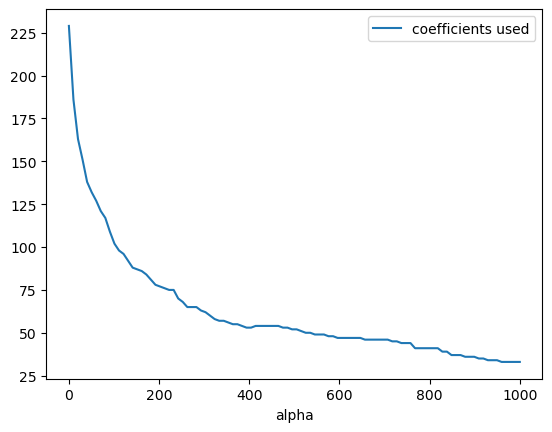

In [75]:
alpha_stats.plot(x='alpha', y='coefficients used', kind='line')

In [76]:
lasso_elbow = Lasso(alpha=200)
lasso_elbow.fit(X_subset_enc, y)

Lasso(alpha=200)

In [77]:
X_subset_enc.columns[lasso_elbow.coef_ != 0]

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       'LowQualFinSF', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold',
       'YrSold', 'MSZoning_RM', 'Alley_No alley', 'LotShape_Reg',
       'LandContour_HLS', 'LotConfig_CulDSac', 'LotConfig_Inside',
       'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Condition1_Norm', 'BldgType_Duplex', 'BldgType_Twnhs',
       'BldgType_TwnhsE', 'HouseStyle_1Story', 'HouseStyle_2Story',
       'HouseStyle_SLvl', 'Exterior1st_BrkFace', 'Exterior1st_Plywood',
       'Exterior1st_Wd Sdng', 'Exterior2nd